# Some Experimentation with Tensorflow Probability

In [1]:
import pandas as pd
from tensorflow_probability import edward2 as ed
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
import sys
sys.executable

'/anaconda3/envs/dl/bin/python'

In [3]:
data = pd.read_csv('fatal_airline_accidents.csv')

In [4]:
y = np.array(data['accidents'])
y = tf.convert_to_tensor(y, dtype=tf.float32)


In [13]:
alpha=tf.convert_to_tensor(np.array([5.0]*10),dtype=tf.float32)
beta=tf.convert_to_tensor(np.array([2.0]*10),dtype=tf.float32)
tfd = tfp.distributions

In [14]:
alpha, beta

(<tf.Tensor 'Const_3:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'Const_4:0' shape=(10,) dtype=float32>)

In [15]:
def accidents_model_prior_predictive_dist(alpha, beta):
    theta = ed.Gamma(concentration=alpha, rate=beta, name="theta")
    accidents = ed.Poisson(rate=theta,name="accidents")
    return accidents
    
accidents_gen = accidents_model_prior_predictive_dist(alpha=alpha, beta=beta)



In [16]:
# inital state
qtheta = tf.random_gamma([10], alpha=5.0, beta=2.0, dtype=tf.float32)
#qtheta = tf.random_normal([], mean=1.0, stddev=3.0, dtype=tf.float32)

In [17]:
qtheta

<tf.Tensor 'random_gamma/Maximum:0' shape=(10,) dtype=float32>

In [18]:
result = []
with tf.Session() as sess:
    for i in range(10000):
        accidents_ = sess.run(accidents_gen)
        result.append(accidents_)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
print('Mean: %s  Var: %s ' % (np.mean(result), np.var(result) ) )

Mean: 2.49438  Var: 3.7474282 


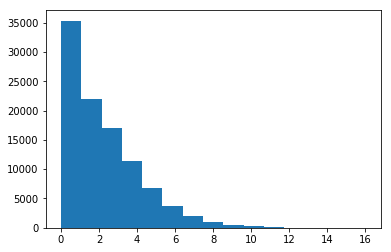

In [21]:
plt.hist(np.array(result).flatten(),bins=15)
plt.show()

In [22]:
log_joint = ed.make_log_joint_fn(accidents_model_prior_predictive_dist)



def target_log_prob_fn(theta):
    """Target log-probability as a function of states."""
    return log_joint(alpha, beta, theta=theta, accidents=y)    

In [26]:
# Initialize the HMC transition kernel.
num_samples = int(10e3)
num_burnin_steps = int(1e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    num_leapfrog_steps=5,
    step_size=0.01)

In [27]:
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=[qtheta],
    num_burnin_steps=num_burnin_steps,
    kernel=hmc)




In [28]:
# sample from posterior
with tf.Session() as sess:
    samples, is_accepted_ = sess.run([samples, kernel_results.is_accepted])
    accepted = np.sum(is_accepted_)
    print("pct accepted: %s"%(accepted / num_samples))



print(samples)

pct accepted: 0.9999
[array([[ 6.746139 ,  7.760075 ,  9.008763 , ...,  5.072694 ,  4.4772816,
         6.278378 ],
       [ 6.7090974,  7.7435775,  8.994854 , ...,  5.026912 ,  4.548915 ,
         6.35964  ],
       [ 6.674753 ,  7.727055 ,  9.020736 , ...,  5.053764 ,  4.6378536,
         6.350527 ],
       ...,
       [10.115327 , 11.060875 , 10.204517 , ...,  8.380159 ,  8.087912 ,
         8.548069 ],
       [10.151785 , 11.03296  , 10.163288 , ...,  8.402973 ,  8.165112 ,
         8.4707155],
       [10.17069  , 10.995087 , 10.170074 , ...,  8.397022 ,  8.152656 ,
         8.500627 ]], dtype=float32)]


In [ ]:
features.shape